## Univariate g-and-k quantile distribution 
#### Braden Scherting
23/02/2019

This notebook implements and performs likelihood-free inference on g-and-k quantile distributions by use of the novel workflow presented in the accompanying Capstone submission. The implementation depends on the `cnvp.py` module included in the submission. Additionally, up-to-date versions of the packages listed in the import cell are necessary, some of which may require up- or downgraded dependencies.

In [1]:
import os, sys
from functools import partial

import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import elfi
from elfi.examples import gnk
import torch

# local module
import cnvp

In [2]:
# Fix random state for reproducibility
seed = 9991

# Experiment setup, 
n_obs = 10 # M observations
n_reps = 1 # replications
n_sims = 35 # N expensive samples per observation

# Simulation settings
gnk_obs = 10000

In [3]:
np.random.seed(seed)

# Priors used by Drovandi and Pettitt (2011)
# Sample "true" parameters
A = ss.uniform.rvs(0, 5, size=n_obs)
B = ss.uniform.rvs(0, 5, size=n_obs)
g = ss.uniform.rvs(-5, 10, size=n_obs)
k = ss.uniform.rvs(-0.5, 5.5, size=n_obs)

# g-and-k parameters used by Drovandi and Pettitt (2011)
# included for comparitive purposes.
A[0] = 3.
B[0] = 1.
g[0] = 2.
k[0] = 0.5

true_params = np.stack((A, B, g, k), 1)
# print(true_params)

# Generate reproducible "observations" from true parameters
# Deterministic, different seeds to ensure uniqueness/independence
all_obs = np.array([[gnk.GNK(A[i], B[i], g[i], k[i], n_obs=gnk_obs, 
                    random_state=np.random.RandomState(seed*(i+n_obs)*(j+n_obs))) 
                     for i in range(n_obs)] for j in range(n_reps)])

### Initial and Reference Inference

The following cell compute the initial, crude posteriors for each observation, computes reference solutions, and trains surrogate likelihoods. For an experiment setup with $M$ observations and $R$ replications, it computes $M\times R$ crude posteriors and $M\times R$ reference posteriors. Only $R$ surrogate likelihoods are trained because a single surrogate corresponds to all $M$ observations. To ensure both reproducibility and non-determinism, seeds are transformed between replications/observations. The cell is organized as follows:
- Create empty lists for storing posteriors, evidence points, and surrogates
- For each replication 
    - Create empty dictionary for storing surrogate training data (`out`)
    - For each observation
        - Instantiate the model using ELFI syntax (`m`)
        - Instantiate inference object (`bolfi`) and fit for predefined `n_sims`
        - Collect evidence points from the initial fit (`ev`)
        - Instantiate reference inference object (`bolfi_ref`) and perform full fit
    - Arrange surrogate training data in appropriate format (`out_data`)
    - Instantiate and train conditional real NVP

_BOLFI Settings:_

The bounds of the BOLFI GP are determined by prior ranges. Because parameter ranges are of roughly the same magnitude, acquisition noise variance is held constant across parameters; the value is chosen to encourage exploration (default is 0). Because, given evidence points, the updating of GPs is largely deterministic, the reference solution is obtained by passing `ev` as initial evidence and proceeding with complete inference. 

In [4]:
crude_posts = [] # (n_obs x n_reps) Initial, crude BOLFI fits
ref_posts = [] # (n_obs x n_reps) Full BOLFI fits for reference
local_evidence = [] # (n_obs x n_reps) Acquired evidence from crude to pass to surrogate fits
evidence_keys = ['A', 'B', 'g', 'k', 'log_d'] # Evidence to retain

all_nvps = [] # (n_reps) global, surrogate likelihoods
all_out = [] # (n_reps, 8, n_sims x n_obs) training data for surrogates


for j in range(n_reps):
    
    # dictionary for saving simulation queries
    out = {'ss_robust': np.array([]), 'A': np.array([]), 'B': np.array([]), 
        'g': np.array([]), 'k': np.array([])}
    
    # Sequential implementation; parallelizable
    for i in range(n_obs):

        # Instatiate model:    
        m = elfi.new_model()
        
        # Priors used by Drovandi and Pettitt (2011)
        # wrapper for scipy.stats distributions
        A = elfi.Prior('uniform', 0, 5, model=m, name='A')
        B = elfi.Prior('uniform', 0, 5, model=m, name='B')
        g = elfi.Prior('uniform', -5, 10, model=m, name='g')
        k = elfi.Prior('uniform', -0.5, 5.5, model=m, name='k')
        
        # Different observations, same parameters per replication
        y_obs = gnk.GNK(*true_params[i], n_obs=gnk_obs, 
                        random_state=np.random.RandomState(seed*(i+n_obs)*(j+n_reps)))
        
        # Pass priors to simulator node
        sim = elfi.Simulator(partial(gnk.GNK, n_obs=gnk_obs), A, B, g, k, observed=y_obs, name='GNK')
        
        # Pass simulations to summary node
        # Sumstats proposed by Drovandi and Pettitt (2011)
        robust_ss = elfi.Summary(gnk.ss_robust, sim, name='ss_robust')
        
        # Pass summaries to discrepancy node
        d = elfi.Discrepancy(gnk.euclidean_multiss, robust_ss, name='d')
        
        # log-scale discrepancy
        log_d = elfi.Operation(np.log, d, name='log_d')
        
        # the obstuse ELFI storage system
        pool = elfi.OutputPool(['A', 'B', 'g', 'k', 'ss_robust', 'd', 'log_d'])
        
        # Different BOLFI random_state across reps
        bolfi = elfi.BOLFI(m, target_name='log_d', bounds={'A':(0,5), 'B':(0,5), 'g':(-5,5), 'k':(-0.5,5)},
                          initial_evidence=20, update_interval=20, acq_noise_var=[0.01]*4, pool=pool,
                          seed=seed*(i+n_obs)+1)
        
        # Crude BOLFI fit
        bolfi.fit(n_sims)    
        crude_posts.append(bolfi)

        ev = {key: np.array(list(pool.get_store(key).values())).flatten()\
                                   for key in evidence_keys}

        local_evidence.append(ev)

        for key in list(out.keys()):
            out[key] = np.append(out[key], np.array(list(pool.get_store(key).values())).flatten(), axis=0)
        
        # Full BOLFI reference solution; not possible in expensive settings
        # Same settings as above, same first n_sims points
        bolfi_ref = elfi.BOLFI(m, target_name='log_d', bounds={'A':(0,5), 'B':(0,5), 'g':(-5,5), 'k':(-0.5,5)},
                          initial_evidence=ev, update_interval=20, acq_noise_var=[0.01]*4, 
                          seed=seed*(i+n_obs)+1)
        
        # Inference does not improve beyond 250 acquisitions
        bolfi_ref.fit(250)
        ref_posts.append(bolfi_ref)
    
    out_data = np.stack((out['ss_robust'][0::4], out['ss_robust'][1::4], out['ss_robust'][2::4], 
                         out['ss_robust'][3::4], out['A'], out['B'], out['g'], out['k']), axis=1)
    all_out.append(out_data)

    # Instantiate surrogate
    # Mask depth defaults to 4
    flow = cnvp.get_nvp(4,4, units=64, seed=seed*j)
    
    # Train surrogate
    # More details in cnvp.py
    flow.train_nvp(out_data, batch_size=10, max_epochs=100, val_split=0.1, threshold=25, 
                   lr_step=20, lr_stepsize=0.3)
    all_nvps.append(flow)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |█████████████████████████████████████████

Can the surrogate match the scale of true simulations? Is there substantial overlap? The next cell quickly checks this. 

[2.15805664 4.88745518 4.0765611  2.72435739]


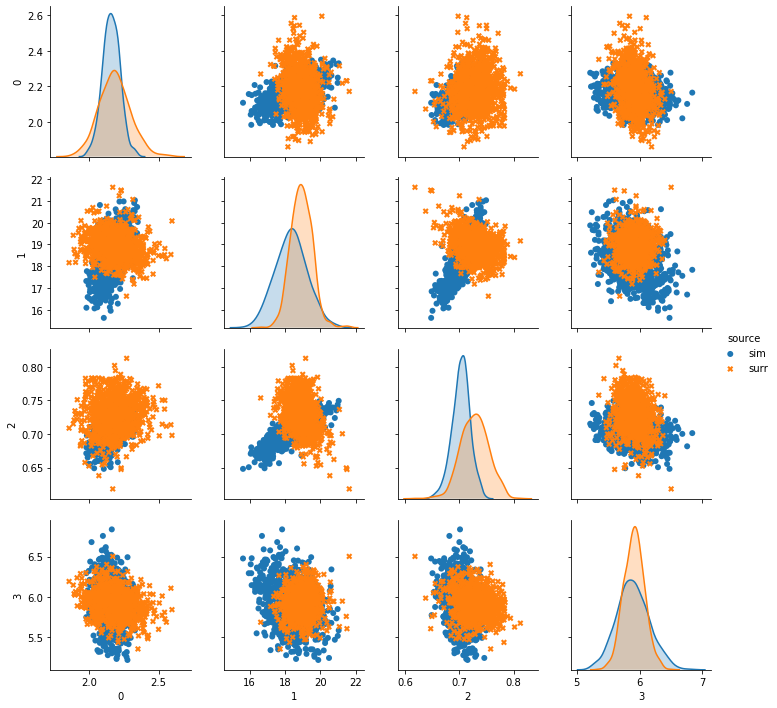

In [5]:
# Visually check surrogate samples (not possible in expensive setting)

# Grab random set of true parameters
theta = true_params[np.random.randint(0,n_obs)]
print(theta)
n_ex = 1000

# Generate `n_ex` true simulations at `theta`
gnk_samps = gnk.ss_robust(gnk.GNK(*theta, n_obs=gnk_obs, batch_size=n_ex)).reshape(n_ex,1,4)[:,0]
df0 = pd.DataFrame(gnk_samps)
df0.insert(0, 'source', value='sim') # Column of zeros for labeling

for j in range(n_reps):
    # Sample `n_ex` surrogate simulations at `theta`
    df1 = pd.DataFrame(all_nvps[j].sample(*theta, batch_size=n_ex).detach().numpy()[:,0,:4])
    df1.insert(0, 'source', value='surr')

    df = df0.append(df1)
    sns.pairplot(df, hue="source", markers=["o", "X"], plot_kws=dict(edgecolor="none"))

### Simulator-Surrogate Swap

The following cell defines functions with the appropriate keyword arguments to be used in the ELFI pipeline. The first, `surr_sample()`, wraps the `cnvp.py` sampling function, with appropriate arguments for batch computation and reproducibility, and returns data of the appropriate type and shape. The second, `surr_model()`, instantiates a model specific to the surrogate. The most notable difference between this and the model building above is the absence of a summary node. Because the surrogate is an approximation to the density $p(T(y)\mid \theta)$, samples are $T_{\theta}(y)$ and no summarization is necessary. 

In [6]:
# Function for sampling from learned surrogate:
def surr_sample(A, B, g, k, cnvp, batch_size=1, random_state=None):
    tensor_samp = cnvp.sample(*torch.from_numpy(np.array([A,B,g,k]).astype(np.float32)), 
                              batch_size=batch_size, random_state=random_state)
    arr_samp = tensor_samp.detach().numpy()
    return arr_samp[:,0,:4].reshape(batch_size, 4, 1)

# ELFI model with surrogate in place of simulator
def surr_model(cnvp, y_obs, seed=None):
    
    m = elfi.new_model()
    
    # Same priors
    priors = []
    priors.append(elfi.Prior('uniform', 0, 5, model=m, name='A'))
    priors.append(elfi.Prior('uniform', 0, 5, model=m, name='B'))
    priors.append(elfi.Prior('uniform', -5, 10, model=m, name='g'))
    priors.append(elfi.Prior('uniform', -0.5, 5.5, model=m, name='k'))
    
    # Depends on `surr_samp()` function, but takes arbitrary surrogate
    fn_simulator = partial(surr_sample, cnvp=cnvp)
    elfi.Simulator(fn_simulator, *priors, observed=y_obs, name='surr_sim')
        
    elfi.Discrepancy(gnk.euclidean_multiss, m['surr_sim'], name='d')
    elfi.Operation(np.log, m['d'], name='log_d')
    
    return m

### Completing Local Inference

To complete the local inferences, for each replication and observation we grab a model with the corresponding observation and surrogate, and perform full inference. Each BOLFI object is given the same initial `n_sims` evidence as the crude and reference fits. All other settings are held constant.

In [7]:
# Complete inference after swapping surrogate/simulator

aug_posts = []

for j in range(n_reps):
    for i in range(n_obs):

        y_obs = gnk.GNK(*true_params[i], n_obs=gnk_obs, 
                        random_state=np.random.RandomState(seed*(i+n_obs)*(j+n_reps)))
        
        # Instantiate surrogate model
        m = surr_model(cnvp=all_nvps[j], y_obs=gnk.ss_robust(y_obs))
        bolfi = elfi.BOLFI(m, target_name='log_d', bounds={'A': (0,5), 'B':(0,5), 'g':(-5,5), 'k':(-0.5,5)},
                          initial_evidence=local_evidence[j*n_obs+i], update_interval=20, acq_noise_var=[0.01]*4, 
                          seed=seed*(i+n_obs)+3)   
        # Full fit
        bolfi.fit(250)

        aug_posts.append(bolfi)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete


### Obtaining Posterior Samples

The following four cells sample from the $3\times M \times R$ GPs generated above. Two diagnostic measures are reported with each posterior sampling run, effective sample size and Rhat. While nearly all pass the diagnostics, samples from the crude samples are decidedly more correlated and the chains are less well-mixed than the reference and augmented samples. This gives some, albeit limited, insight into the natures of each type of posterior. The crude posteriors are broader (slower to traverse) and possibly multi-modal. If we assume that the reference posteriors are converged, then the fact that the augmented sample diagnostics more closely resemble those of reference samples than crude samples suggests convergence of augmented posteriors. 

In [8]:
# Sample the BOLFI posteriors to obtain posterior samples
def bolfi_sampling(posteriors, n_samps=7500):
    samples = []
    for k in range(len(posteriors)):
        # proposal standard deviation chosen to be parameter range / 20
        samples.append(posteriors[k].sample(n_samps, algorithm='metropolis', 
                                            sigma_proposals=np.array([0.25,0.25,0.5,0.275])).samples_array)
        
        if k % 10 == 1:
            print(k)
    return samples

In [9]:
# Sample crude posteriors (dotted line)
crude_samps = bolfi_sampling(crude_posts)

4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 159.5597850291717 1.0075120487301727
B 157.2269006949509 1.0114126857160215
g 110.9787752774291 1.0434582478190997
k 134.02992575813226 1.058422129480114
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 160.52267321486914 1.0182682965894994
B 148.08833626047743 1.0367027131233904
g 189.389343200154 1.020486900476824
k 116.28106780906454 1.0365896247128272
1
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 138.32445320250332 1.0266282170818817
B 132.30162499744333 1.0261105984584835
g 120.80969911747856 1.0109107770124657
k 154.2953262530557 1.011578085034839
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 86.24915455823368 1.0480235490868344
B 197.97210289944957 1.0699303308399806
g 172.41723139296184 1.0241342617358224
k 185.29017302467514 1.0393886325047534
4 chains of 

In [10]:
# Sample reference posteriors (solid black)
ref_samps = bolfi_sampling(ref_posts)

4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 921.9425362214868 1.0013776825626435
B 1648.1330539105936 1.0026904607396872
g 636.4681406908063 1.007420542049311
k 2054.0581034555967 1.0032257983707686
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 1291.7574625949105 1.0042139862480364
B 983.0924846809725 1.0069712775979471
g 828.1417453141975 1.006031749739167
k 1441.9044964400293 1.0030644272483398
1
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 736.5445424989018 1.008181134636143
B 948.4789981566141 1.0000051665744785
g 547.2124400674342 1.004823254831886
k 1373.5961449477538 1.0026300355591853
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 209.7019500250305 1.0095233252408882
B 759.1084067476646 1.008239513392821
g 79.4613685019143 1.0339081777894654
k 1095.9152425396492 1.0051354040663245
4 chains of 7500 i

In [11]:
# Sample workflow posteriors (dashed red)
aug_samps = bolfi_sampling(aug_posts)

4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 981.4080607959461 1.0016516473371333
B 1080.550836736326 1.0058472012250799
g 531.2495869205943 1.0022038149915533
k 1566.0217218700616 1.0015857353885897
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 949.361761464951 1.0041848319357423
B 713.4406635082472 1.0052832786577726
g 545.0693898628057 1.0049230466023011
k 1068.2544142643528 1.0035270389328794
1
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 643.2520768896838 1.0048657668384329
B 931.133525415092 1.0059335981668533
g 374.8319320979913 1.011268810538842
k 1419.7577914171454 1.0025604561223544
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 268.95430721790694 1.0138583635791245
B 985.6139601573166 1.0047453519034786
g 147.7692361919565 1.0156308918127137
k 1241.7654021079577 1.0018326687291568
4 chains of 7500

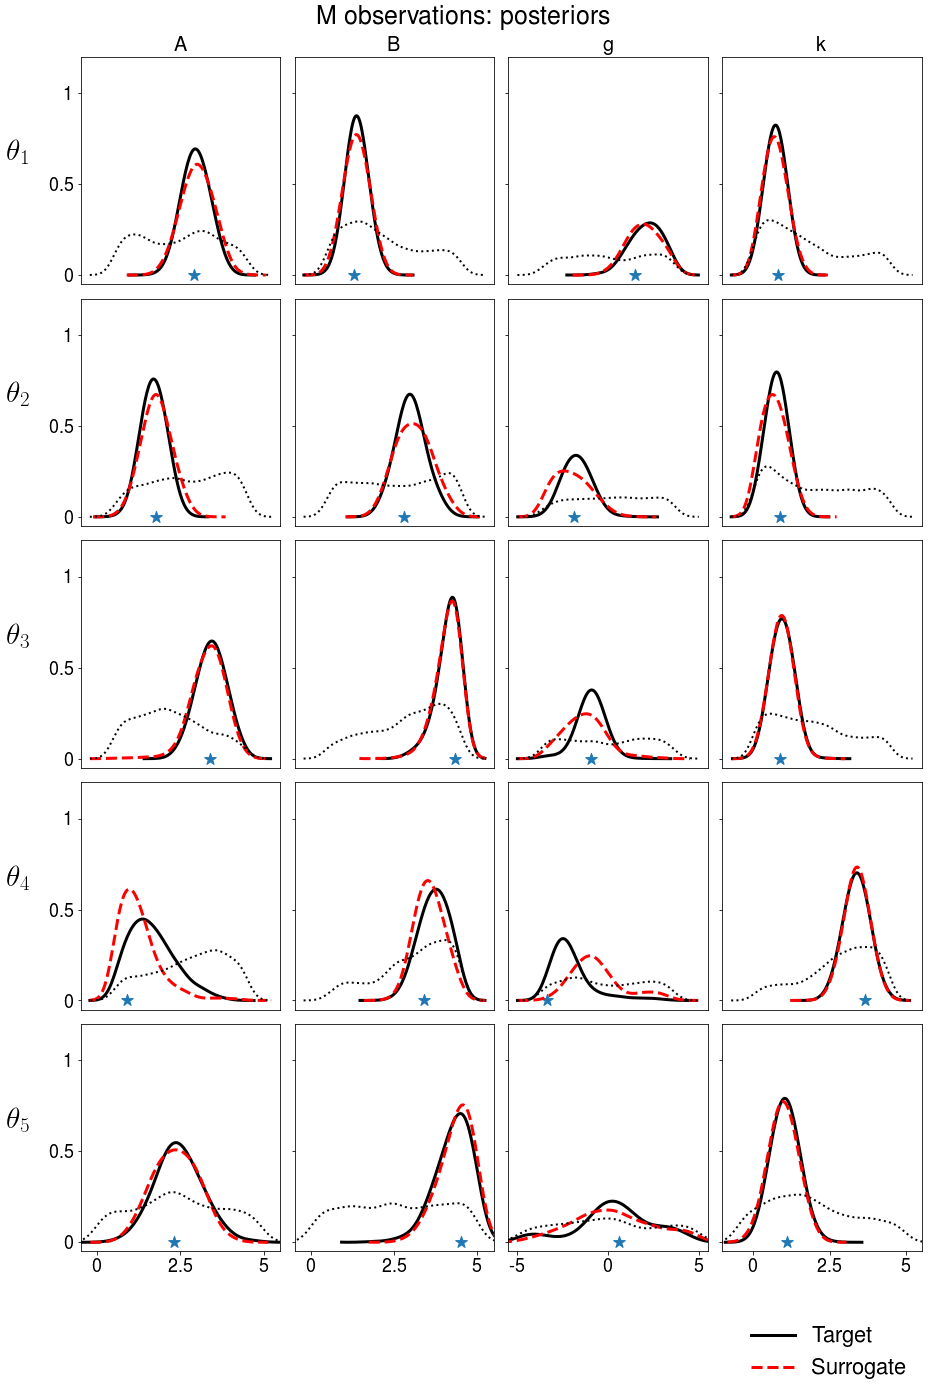

In [65]:
show = 5
fig, axes = plt.subplots(show, 4, sharex=False, sharey=True, figsize=(13,3.5*show))

# Smoothness without loss of detail
bws = [0.3,0.3,0.6,0.3]
letters = ['A', 'B', 'g', 'k']
x_lims = [[-0.5,5.5],[-0.5,5.5],[-5.5,5.5],[-1,5.5]]

x_ticks = [[0,2.5,5],
           [0,2.5,5],
           [-5,0,5],
           [0,2.5,5]]

for j in range(show):
    df0 = pd.DataFrame(crude_samps[j][7500::5])
    df1 = pd.DataFrame(aug_samps[j][7500::5])
    df2 = pd.DataFrame(ref_samps[j][7500::5])
    axes[j,0].set_ylabel(r'$\theta_{ %d }$'%(j+1), rotation=0, fontsize=30)
    axes[j,0].yaxis.labelpad = 30
    
    for i in range(4):
        sns.kdeplot(df2[i], ax=axes[j,i], bw=bws[i], legend=False, color='black', linewidth=3)
        sns.kdeplot(df1[i], ax=axes[j,i], bw=bws[i], legend=False, color='red', linestyle='dashed',linewidth=3)
        sns.kdeplot(df0[i], ax=axes[j,i], bw=bws[i], linestyle='dotted', legend=False, color='black',linewidth=2)

        
        axes[j,i].set_xticks([])
        
        axes[j,i].scatter(true_params[j, i], 0, marker='*', s=150)

    
for ax, col in zip(axes[0], letters):
    ax.set_title(col, fontdict={'fontsize':20})

for ax, lim, tick in zip(axes[-1], x_lims, x_ticks):
    ax.set_xlim(lim)
    ax.set_xticks(tick)
    ax.set_xticklabels(tick,fontsize=18) 

for ax in axes[:,0]:
    ax.set_ylim([-0.05,1.2])
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels([0,0.5,1],fontsize=18) 

    
fig.tight_layout()
fig.suptitle('M observations: posteriors', fontsize=25, y=1.015)
plt.legend(['Target', 'Surrogate'], loc=(0.1,-0.6), fontsize=22, framealpha=0)

plt.show()

### Sample-free Inference

The following four cells evaluate sample-free inference. The first cell samples new parameters (not from the original "true" parameters). Next, inference is performed on two models, one with full access to the simulator (same as reference posteriors above) and one with access _only to the surrogate._ This differs from the inference performed above in that this raw inference proceeds with zero expensive simulations, whereas the above inference used `n_sims`. All other settings remain the same as above. Both reference and raw posteriors are then sampled, as above, and the results are displayed. 

In [13]:
a1_new = ss.uniform.rvs(0, 5, size=1)
b1_new = ss.uniform.rvs(0, 5, size=1)
g1_new = ss.uniform.rvs(-5, 10, size=1)
k1_new = ss.uniform.rvs(-0.5, 5.5, size=1)

new_p = np.stack((a1_new, b1_new, g1_new, k1_new,), 1)

new_obs = gnk.GNK(*new_p[0], 
                      n_obs=gnk_obs, random_state=np.random.RandomState(seed))

print(new_p)

[[0.05189836 2.57042495 4.95637355 1.11374482]]


In [14]:
m = elfi.new_model()

# Priors used by Drovandi and Pettitt (2011)
priors = []
priors.append(elfi.Prior('uniform', 0, 5, model=m, name='A'))
priors.append(elfi.Prior('uniform', 0, 5, model=m, name='B'))
priors.append(elfi.Prior('uniform', -5, 10, model=m, name='g'))
priors.append(elfi.Prior('uniform', -.5, 5.5, model=m, name='k'))

# Different obs, same params per replication
y_obs = new_obs

sim = elfi.Simulator(partial(gnk.GNK, n_obs=gnk_obs), *priors, observed=y_obs, name='GNK')
        
# Sumstats proposed by Drovandi and Pettitt (2011)
robust_ss = elfi.Summary(gnk.ss_robust, sim, name='ss_robust')
d = elfi.Discrepancy(gnk.euclidean_multiss, robust_ss, name='d')

# log-scale discrepancy -- it seems to work better
log_d = elfi.Operation(np.log, d, name='log_d')

# Different BOLFI random_state across reps
ref_bolfi = elfi.BOLFI(m, target_name='log_d', bounds={'A':(0,5), 'B':(0,5), 'g':(-5,5), 'k':(-0.5,5)},
                  initial_evidence=20, update_interval=20, acq_noise_var=[0.01]*4, 
                  seed=seed)

# Crude BOLFI fit
ref_bolfi.fit(250)  

m = surr_model(all_nvps[0], gnk.ss_robust(new_obs))
raw_bolfi = elfi.BOLFI(m, target_name='log_d', bounds={'A':(0,5), 'B':(0,5), 'g':(-5,5), 'k':(-0.5,5)},
                  initial_evidence=20, update_interval=20, 
                  acq_noise_var=[0.01,0.01,0.01,0.01], 
                  seed=seed)   
# Full fit
raw_bolfi.fit(250)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [15]:
n_samps = 7500
raw_samps = raw_bolfi.sample(n_samps, algorithm='metropolis', 
                             sigma_proposals=np.array([0.25,0.25,0.5,0.275])).samples_array

ref2_samps = ref_bolfi.sample(n_samps, algorithm='metropolis', 
                              sigma_proposals=np.array([0.25,0.25,0.5,0.275])).samples_array

4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 912.333147506578 1.0055606565515538
B 448.6361457709468 1.0098214665937224
g 417.8263579870328 1.0131535227273947
k 586.4191378146879 1.0077766240228299
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
A 700.5640024893293 1.0064115978016628
B 481.1179290093947 1.010754603805572
g 317.2164207330412 1.0120391599703797
k 592.3805733850922 1.0066699547550684


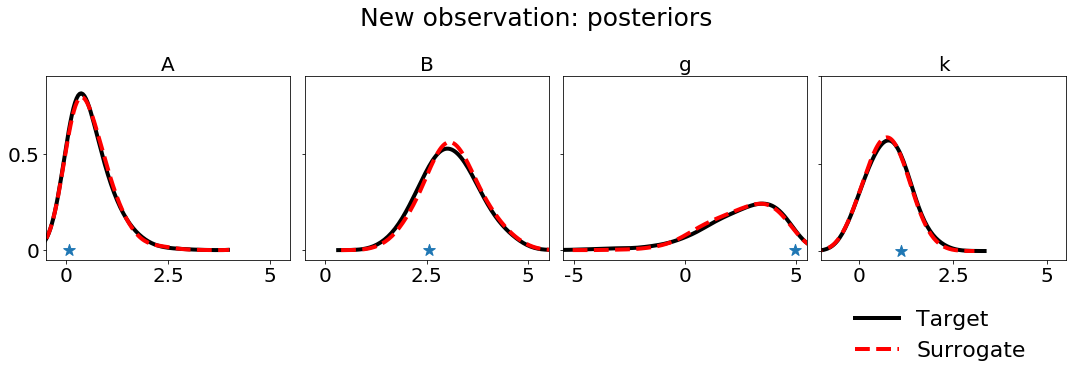

In [16]:
fig, axes = plt.subplots(1, 4, sharex=False, sharey=True, figsize=(15,3.5))

df1 = pd.DataFrame(raw_samps[7500::5])
df2 = pd.DataFrame(ref2_samps[7500::5])

for i in range(4):
    a = sns.kdeplot(df2[i], ax=axes[i], bw=bws[i], legend=False, color='black', linewidth=4)
    b = sns.kdeplot(df1[i], ax=axes[i], bw=bws[i], legend=False, color='red',linestyle='dashed', linewidth=4)


    axes[i].set_xticks([])

    axes[i].scatter(new_p[0,i], 0, marker='*', s=150)
    
for ax, col in zip(axes, letters):
    ax.set_title(col, fontdict={'fontsize':20})

for ax, lim, tick in zip(axes, x_lims, x_ticks):
    ax.set_xlim(lim)
    ax.set_xticks(tick)
    ax.set_xticklabels(tick,fontsize=20) 

for ax in axes:
    ax.set_ylim([-0.05,0.9])
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels([0,0.5,1],fontsize=20) 


fig.tight_layout()
fig.suptitle('New observation: posteriors', fontsize=25, y=1.15)
plt.legend(['Target', 'Surrogate'], loc=(0.1,-0.6), fontsize=22, framealpha=0)

plt.show()

The following cells are used for computing and reporting 95% credible intervals for each marginal posterior. The printed outputs can be pasted directly into a \tabular environment in a LaTeX editor. The final cell computes and reports the average improvement made by the augmented posteriors. However, the metric used, absolute mean sample error, does not capture higher order moments and thus produces misleading results. These are not included in the paper.  

In [1]:
# Compute relevant percentiles of each thinned sample array
crude_p = np.percentile(np.array(crude_samps[:,7500::5]), q=[2.5, 97.5], axis=1)
ref_p = np.percentile(np.array(ref_samps[:,7500::5]), q=[2.5, 97.5], axis=1)
aug_p = np.percentile(np.array(aug_samps[:,7500::5]), q=[2.5, 97.5], axis=1)

# Obtain CI width by subtraction
crude_ci = crude_p[1] - crude_p[0]
ref_ci = ref_p[1] - ref_p[0]
aug_ci = aug_p[1] - aug_p[0]

NameError: name 'np' is not defined

In [64]:
# Set parameter table to generate
p = 0

for i in range(n_obs):
    print(f"$\\theta = {true_params[i,p]:.2f} $& \
          ({crude_p[:,i,p][0]:.2f}, {crude_p[:,i,p][1]:.2f}) & \
          ({ref_p[:,i,p][0]:.2f}, {ref_p[:,i,p][1]:.2f}) & \
          ({aug_p[:,i,p][0]:.2f}, {aug_p[:,i,p][1]:.2f}) \\\ ")
print('\\hline')
print(f"Avg width & {crude_ci[:,p].mean():.2f} & {ref_ci[:,p].mean():.2f} & {aug_ci[:,p].mean():.2f} \\\ ")
print(f"Avg Reduction & - & {(crude_ci - ref_ci)[:,p].mean():.2f} & \
{(crude_ci - aug_ci)[:,p].mean():.2f} \\\ ")


$\theta = 0.50 $&           (-0.42, 4.76) &           (-0.33, 1.09) &           (-0.38, 1.20) \\ 
$\theta = 0.56 $&           (-0.41, 4.88) &           (-0.29, 1.15) &           (-0.44, 1.32) \\ 
$\theta = 0.58 $&           (-0.40, 4.81) &           (-0.13, 1.40) &           (-0.14, 1.38) \\ 
$\theta = 4.00 $&           (-0.28, 4.90) &           (2.74, 4.54) &           (2.78, 4.56) \\ 
$\theta = 1.13 $&           (-0.34, 4.78) &           (0.33, 1.82) &           (0.19, 1.80) \\ 
$\theta = 2.72 $&           (-0.39, 4.84) &           (1.48, 3.57) &           (1.81, 3.36) \\ 
$\theta = 3.63 $&           (-0.37, 4.74) &           (2.19, 4.00) &           (2.32, 4.08) \\ 
$\theta = 3.85 $&           (-0.40, 4.77) &           (3.11, 4.20) &           (3.14, 4.21) \\ 
$\theta = 0.46 $&           (-0.35, 4.88) &           (-0.11, 1.44) &           (-0.20, 1.32) \\ 
$\theta = 3.51 $&           (-0.36, 4.85) &           (1.95, 3.98) &           (2.47, 3.87) \\ 
\hline
Avg width & 5.19 & 1.62 &

In [58]:
for i in range(n_obs):
    m1 = np.abs(np.mean(crude_samps[i][7500::5] - ref_samps[i][7500::5], 0))
    m2 = np.abs(np.mean(aug_samps[i][7500::5] - ref_samps[i][7500::5], 0))
    
    # Improvement made by workflow over crude relative to reference
    mean = 100*((m1 - m2) / m1)
    
    print(f"$p(\\theta_{ {i} } \\mid y_{ {i} } )$& \
    {mean[0]:.2f} &  {mean[1]:.2f} & {mean[2]:.2f} & {mean[3]:.2f} \\\ ")

$p(\theta_{0} \mid y_{0} )$&     91.69 &  97.92 & 93.41 & 98.69 \\ 
$p(\theta_{1} \mid y_{1} )$&     91.53 &  77.61 & 84.82 & 93.73 \\ 
$p(\theta_{2} \mid y_{2} )$&     92.50 &  99.06 & 62.51 & 98.46 \\ 
$p(\theta_{3} \mid y_{3} )$&     64.93 &  76.36 & 25.39 & 98.46 \\ 
$p(\theta_{4} \mid y_{4} )$&     -984.01 &  94.72 & 76.27 & 92.86 \\ 
$p(\theta_{5} \mid y_{5} )$&     -41.09 &  89.25 & -446.25 & 84.97 \\ 
$p(\theta_{6} \mid y_{6} )$&     89.04 &  83.07 & -160.36 & 89.26 \\ 
$p(\theta_{7} \mid y_{7} )$&     85.65 &  98.59 & -3053.69 & 98.57 \\ 
$p(\theta_{8} \mid y_{8} )$&     88.45 &  94.27 & 86.23 & 93.33 \\ 
$p(\theta_{9} \mid y_{9} )$&     73.51 &  6.53 & 94.37 & 68.11 \\ 
